In [243]:
using PhotoAcoustic
using JUDI
using Flux
using ProgressMeter: Progress, next!
using MLDatasets
using PyPlot
using ChainRulesCore
using Statistics
using LinearAlgebra
using Images

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1423
┌ Warning: Module SpecialFunctions with build ID 1309683942412108 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module SpecialFunctions with build ID 1309683942412108 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module SpecialFunctions with build ID 1309683942412108 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module SpecialFunctions with build ID 1309683942412108 is missing from the cache.
│ This may mean SpecialFunctions

┌ Info: Skipping precompilation since __precompile__(false). Importing ImageMorphology [787d08f9-d448-5407-9aad-5290dd7ab264].
└ @ Base loading.jl:1124
┌ Info: Precompiling ImageDistances [51556ac3-7006-55f5-8cb3-34580c88182d]
└ @ Base loading.jl:1423
┌ Warning: Module ImageCore with build ID 1315598649482375 is missing from the cache.
│ This may mean ImageCore [a09fc81d-aa75-5fe9-8630-4744c3626534] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing ImageDistances [51556ac3-7006-55f5-8cb3-34580c88182d].
└ @ Base loading.jl:1124
┌ Info: Precompiling ImageContrastAdjustment [f332f351-ec65-5f6a-b3d1-319c6670881a]
└ @ Base loading.jl:1423
┌ Warning: Module ImageCore with build ID 1315598649482375 is missing from the cache.
│ This may mean ImageCore [a09fc81d-aa75-5fe9-8630-4744c3626534] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl

In [27]:
struct UNet
    layers::NamedTuple
end

In [163]:
"""
User Facing API for UNet architecture.
"""
function UNet(channels=[32, 64, 128, 256], embed_dim=256, scale=30.0f0)
    return UNet((
        gaussfourierproj=GaussianFourierProjection(embed_dim, scale),
        linear=Dense(embed_dim, embed_dim, swish),
        # Encoding
        conv1=Conv((3, 3), 1 => channels[1], stride=1, bias=false),
        dense1=Dense(embed_dim, channels[1]),
        gnorm1=GroupNorm(channels[1], 4, swish),
        conv2=Conv((3, 3), channels[1] => channels[2], stride=2, bias=false),
        dense2=Dense(embed_dim, channels[2]),
        gnorm2=GroupNorm(channels[2], 32, swish),
        conv3=Conv((3, 3), channels[2] => channels[3], stride=2, bias=false),
        dense3=Dense(embed_dim, channels[3]),
        gnorm3=GroupNorm(channels[3], 32, swish),
        conv4=Conv((3, 3), channels[3] => channels[4], stride=2, bias=false),
        dense4=Dense(embed_dim, channels[4]),
        gnorm4=GroupNorm(channels[4], 32, swish),
        # Decoding
        tconv4=ConvTranspose((3, 3), channels[4] => channels[3], stride=2, bias=false),
        dense5=Dense(embed_dim, channels[3]),
        tgnorm4=GroupNorm(channels[3], 32, swish),
        tconv3=ConvTranspose((3, 3), channels[3] + channels[3] => channels[2], pad=(0, -1, 0, -1), stride=2, bias=false),
        dense6=Dense(embed_dim, channels[2]),
        tgnorm3=GroupNorm(channels[2], 32, swish),
        tconv2=ConvTranspose((3, 3), channels[2] + channels[2] => channels[1], pad=(0, -1, 0, -1), stride=2, bias=false),
        dense7=Dense(embed_dim, channels[1]),
        tgnorm2=GroupNorm(channels[1], 32, swish),
        tconv1=ConvTranspose((3, 3), channels[1] + channels[1] => 1, stride=1, bias=false),
    ))
end

Flux.@functor UNet

In [222]:
expand_dims(x::AbstractVecOrMat, dims::Int=2) = reshape(x, (ntuple(i -> 1, dims)..., size(x)...))
expand_dims_rev(x::AbstractVecOrMat, dims::Int=2) = reshape(x,  size(x)...,(ntuple(i -> 1, dims)...))

expand_dims_rev (generic function with 2 methods)

In [165]:
function (unet::UNet)(x)

    # Encoder
    h1 = unet.layers.conv1(x)
    h1 = unet.layers.gnorm1(h1)
    
    h2 = unet.layers.conv2(h1)
    h2 = unet.layers.gnorm2(h2)
    
    h3 = unet.layers.conv3(h2)
    h3 = unet.layers.gnorm3(h3)
    
    h4 = unet.layers.conv4(h3)
    h4 = unet.layers.gnorm4(h4)
    
    # Decoder
    h = unet.layers.tconv4(h4)
    h = unet.layers.tgnorm4(h)
    
    h = unet.layers.tconv3(cat(h, h3; dims=3))
    h = unet.layers.tgnorm3(h)
    
    h = unet.layers.tconv2(cat(h, h2, dims=3))
    h = unet.layers.tgnorm2(h)
    
    h = unet.layers.tconv1(cat(h, h1, dims=3))
end

# Define photoacoustic simulation

In [178]:
# Set up model structure
n = (64, 64)   # (x,y,z) or (x,z)
d = (0.08f0, 0.08f0)
o = (0., 0.)

# Constant water velocity [mm/microsec]
v = 1.5*ones(Float32,n) 
m = (1f0 ./ v).^2

# Setup model structure
model = Model(n, d, o, m;nb=10)

# Set up receiver geometry
nxrec = 64
xrec = range(0, stop=d[1]*(n[1]-1), length=nxrec)
yrec = [0f0]
zrec = range(0, stop=0, length=nxrec)

# receiver sampling and recording time
time = 5.2333 #[microsec] 
dt = calculate_dt(model) / 2    

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=1)

# Setup operators
opt = Options(dt_comp=dt)
F = judiModeling(model; options=opt)
A = judiPhoto(F, recGeometry;)

JUDI forward{Float32} propagator (z * x) -> (src * rec * time)

## Get model x

In [274]:
xtrain, ytrain = MLDatasets.MNIST(:train)[:]
x = judiPhotoSource(imresize(xtrain[:,:,1], (n[1], n[2])))

judiPhotoSource{Float32} with 1 sources


# Make observed data 

In [245]:
y = A*x
imshow(y.data[1];aspect="auto")

Operator `photoacoustic_forward` ran in 0.01 s


judiVector{Float32, Matrix{Float32}} with 1 sources


In [247]:
function ChainRulesCore.rrule(::typeof(*), A::T, x) where {T<:judiPhoto}
    y = A*judiPhotoSource(x)
    pullback(Δy) = (NoTangent(), NoTangent(), expand_dims_rev((A'*Δy).data[1]))
    return y, pullback
end


In [248]:
function model_loss(A, model, y, z)
    norm(A*model(z) - y).^2
end

model_loss (generic function with 1 method)

## Training Hyperparameters 

In [257]:
device = cpu
lr = 1e-4               # learning rate
epochs = 50           # number of epochs

50

In [258]:
# initialize UNet model
unet = UNet() |> device

# initialize input to model. This is not a trainable parameter 
z = randn(Float32, n[1], n[1], 1, 1)

# ADAM optimizer
opt = ADAM(lr)

# trainable parameters
ps = Flux.params(unet);

## Training

In [260]:
progress = Progress(epochs)
loss_log = []
for epoch = 1:epochs
    @info "Epoch $(epoch)"
    
    loss, grad = Flux.withgradient(ps) do
        model_loss(A, unet, y, z)
    end
    Flux.Optimise.update!(opt, ps, grad)
    
    # progress meter
    next!(progress; showvalues=[(:loss, loss)])
    append!(loss_log, loss)
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/rafaelorozco/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress: 100%|█████████████████████████████████████████| Time: 0:02:25
  loss:  0.18887182


## Show training log

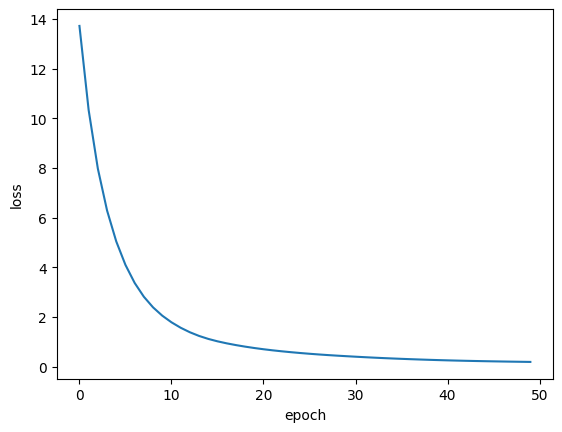

In [261]:
plot(loss_log);
xlabel("epoch"); ylabel("loss"); 

## Plot our results

Operator `photoacoustic_forward` ran in 0.01 s
Operator `photoacoustic_forward` ran in 0.02 s


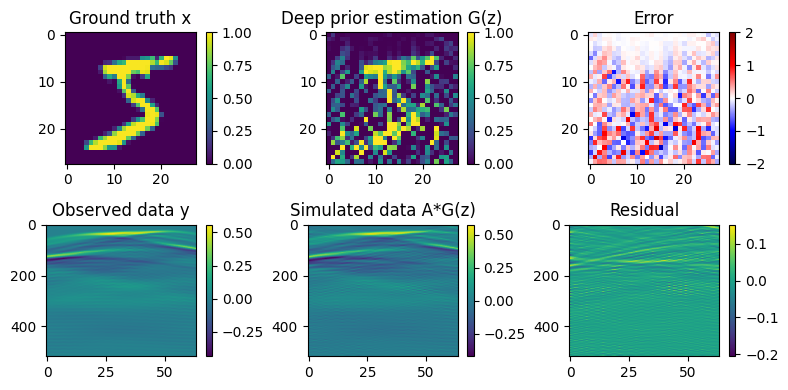

In [273]:
fig = figure(figsize=(8,4))
subplot(2,3,1); title("Ground truth x")
imshow(x.data[1][:,:,1,1]'; vmin=0,vmax = 1); colorbar()
subplot(2,3,2); title("Deep prior estimation G(z)")
imshow(unet(z)[:,:,1,1]'; vmin=0,vmax = 1); colorbar() 
subplot(2,3,3); title("Error")
imshow(unet(z)[:,:,1,1]' - x.data[1][:,:,1,1]'; cmap = "seismic", vmin=-2, vmax = 2); colorbar()

subplot(2,3,4); title("Observed data y")
imshow(y.data[1];aspect="auto"); colorbar()
subplot(2,3,5); title("Simulated data A*G(z)")
imshow((A*judiPhotoSource(unet(z))).data[1];aspect="auto"); colorbar() 
subplot(2,3,6); title("Residual")
imshow((A*judiPhotoSource(unet(z))).data[1] - y.data[1];aspect="auto");  colorbar() 

tight_layout()